### Importing Libraries

In [1]:
import os
from IPython import display
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array

### Data Processing

In [7]:
data_dir = "Dataset/train/Stage_4"

img_width, img_height = 224, 224
batch_size = 32

# Load all images from the folder
def load_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        img = load_img(os.path.join(folder_path, filename), target_size=(img_width, img_height))
        img_array = img_to_array(img)
        gray = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
        img_tensor = tf.convert_to_tensor(gray)
        images.append(img_tensor)
    return np.array(images)

# Load images from the folder
train = load_images_from_folder(data_dir)

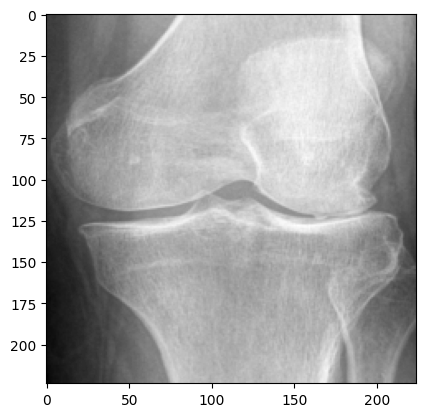

In [8]:
plt.imshow(train[5], cmap='gray')

### DCGAN

In [12]:
# Generator
# def build_generator(latent_dim):
#     input_noise = Input(shape=(latent_dim,))
#     x = Dense(7*7*256)(input_noise)
#     x = Reshape((7, 7, 256))(x)
#     x = Conv2DTranspose(128, kernel_size=5, strides=1, padding='same')(x)
#     x = BatchNormalization()(x)
#     x = LeakyReLU(alpha=0.01)(x)
#     x = Conv2DTranspose(64, kernel_size=5, strides=2, padding='same')(x)
#     x = BatchNormalization()(x)
#     x = LeakyReLU(alpha=0.01)(x)
#     x = Conv2DTranspose(1, kernel_size=5, strides=2, padding='same', activation='tanh')(x)
#     generator = Model(input_noise, x)
#     return generator

def build_generator(latent_dim):
    input_noise = Input(shape=(latent_dim,))
    x = Dense(7*7*256)(input_noise)
    x = Reshape((7, 7, 256))(x)
    x = Conv2DTranspose(128, kernel_size=5, strides=4, padding='same')(x)  # Adjust the strides to upscale to 28x28
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Conv2DTranspose(64, kernel_size=5, strides=4, padding='same')(x)  # Adjust the strides to upscale to 112x112
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Conv2DTranspose(1, kernel_size=5, strides=2, padding='same', activation='tanh')(x)  # Adjust the strides to upscale to 224x224
    generator = Model(input_noise, x)
    return generator

# Discriminator
def build_discriminator(input_shape):
    input_image = Input(shape=input_shape)
    x = Conv2D(64, kernel_size=5, strides=2, padding='same')(input_image)
    x = LeakyReLU(alpha=0.01)(x)
    x = Conv2D(128, kernel_size=5, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Flatten()(x)
    x = Dense(1, activation='sigmoid')(x)
    discriminator = Model(input_image, x)
    return discriminator

# Combined model
def build_dcgan(generator, discriminator):
    discriminator.trainable = False
    input_noise = Input(shape=(latent_dim,))
    generated_image = generator(input_noise)
    validity = discriminator(generated_image)
    dcgan = Model(input_noise, validity)
    return dcgan

# Define the input shape and latent dimension
input_shape = (224, 224, 1)
latent_dim = 100

# Build the generator, discriminator, and DCGAN models
generator = build_generator(latent_dim)
discriminator = build_discriminator(input_shape)
dcgan = build_dcgan(generator, discriminator)

# Compile the discriminator and DCGAN models
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
dcgan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

In [13]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [14]:
epochs = 1000
batch_size = 64

seed = tf.random.normal([16, 100])

# Train the DCGAN model
for epoch in range(epochs):
    for batch in range(train.shape[0] // batch_size):
        # Train the discriminator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_images = generator.predict(noise)
        real_images = train[np.random.randint(0, train.shape[0], batch_size)]
        discriminator_loss_real = discriminator.train_on_batch(real_images, np.ones(batch_size))
        discriminator_loss_fake = discriminator.train_on_batch(fake_images, np.zeros(batch_size))
        discriminator_loss = 0.5 * np.add(discriminator_loss_real, discriminator_loss_fake)
        
        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        generator_loss = dcgan.train_on_batch(noise, np.ones(batch_size))
    
    # Print the losses
    print(f"Epoch {epoch+1}/{epochs} - Discriminator Loss: {discriminator_loss} - Generator Loss: {generator_loss}")

display.clear_output(wait=True)
generate_and_save_images(generator, epochs, seed)

2/2 [==============================] - 0s 189ms/step
Epoch 1/500 - Discriminator Loss: 20.73663231730461 - Generator Loss: 0.6571862697601318
2/2 [==============================] - 1s 291ms/step


KeyboardInterrupt: 